<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_16_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%B7%D0%B0%D1%80%D0%BF%D0%BB%D0%B0%D1%82%D1%8B_%D0%BD%D0%B0_%D0%B1%D0%B0%D0%B7%D0%B5_HeadHunter%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                                       
import pandas as pd

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop 
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 


import random 
import math 
import re 
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fixed_df = pd.read_csv("/content/drive/My Drive/hh_fixed.csv")   

In [ ]:

print(fixed_df.shape)

(62967, 13)


In [ ]:
fixed_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
n = 12
for i in range(len(fixed_df.values[n])): 
  print(i, ":", fixed_df.values[n][i])

0 : 12
1 : Мужчина ,  54 года , родился 27 июня 1964
2 : 180000 руб.
3 : Ведущий разработчик ORACLE
4 : Москва ,  м. Бульвар Рокоссовского , не готов к переезду , не готов к командировкам
5 : полная занятость
6 : гибкий график, полный день, удаленная работа
7 : Опыт работы 30 лет 9 месяцев  Ведущий разработчик ORACLE 180 000 руб. Информационные технологии, интернет, телеком Банковское ПО Программирование, Разработка Администратор баз данных Занятость: полная занятость График работы: гибкий график, полный день, удаленная работа Опыт работы 30 лет 9 месяцев Июнь 1993 — по настоящее время 25 лет 11 месяцев Государственная корпорация “Банк развития и внешнеэкономической деятельности (ВНЕШЭКОНОМБАНК)”, Москва Москва , www.veb.ru Финансовый сектор ... Банк Управляющая, инвестиционная компания (управление активами) Бизнес-аналитик / Разработчик ПО В составе коллектива программистов прошел полный цикл разработки и сопровождения программного обеспечения для Автоматизированной Банковской Системы

In [ ]:

####Убрать кодировку в описаниях \xa0 \n
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1)     # Убираем первый столбец с индексами

i=0
for j in range(12):                                        # Для каждого из столбцов таблицы
    for i in range(fixed_df.shape[0]):                     # По всем резюме
        if type(fixed_df.values[i][j])!=float:             # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")

In [ ]:
def getParameterSexAge(arg): # функция возраста
    out = [0,0]                # 1й ноль - это женский пол, 2й ноль - возраст
  
    if "М" in arg:  
      out[0] = 1
  
    year_tec = 2021
    if (len(arg) > 7):
        out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
    return out

In [ ]:
def getParameterAgeVect(arg):   # функция  возраст превращааю в класс возрастной категории
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))

    return list(utils.to_categorical(outClass, 11).astype('int'))  # На выходе получаем вектор с нужной категорией возраста

In [ ]:
def getParameterSalary(arg):               # функция зарплаты (salary-зарплата)
    num = arg
    
    if (type(num) == str):
        num = re.sub(' ','',num)           # sub рег выражение,ищет шаблон и меняет
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')          # replace-строковый метод.замена 
        
        
        curr = re.sub('[0-9]','',arg)        # в curr кладу название валюты(USD,KZT...)
        curr = curr.replace('.','').strip()  # strip-удалит пробелы с обоих концов строки.
        
        # Конвертирую curr в рубли и кладу в num
        if curr == 'USD':
           num = float(num)*85               # это курс
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
             
    salaryStr = int(num) 
    
    return salaryStr


In [ ]:
def getParameterCity(arg):   # функция городов

    millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
    sarg=arg.split(',')

    for item in sarg:
        item= item.strip()
        if item == "Москва":          return [1, 0, 0, 0]
        if item == "Санкт-Петербург": return [0, 1, 0, 0]
        if item in millionCities:     return [0, 0, 1, 0]
        
    return [0, 0, 0, 1]

In [ ]:
def getParameterEmployment(arg):    # функция желаемой занятости

    out= [0, 0, 0, 0]
    
    if ("стажировка" in arg):           out[0]=1
    if ("частичная занятость" in arg):  out[1]=1
    if ("проектная работа" in arg):     out[2]=1
    if ("полная занятость" in arg):     out[3]=1

    return out

In [ ]:
def getParameterSchedule(arg):   # функция о желаемом графике работы

    out = [0, 0, 0, 0]

    if ("гибкий график" in arg):    out[0]=1
    if ("полный день" in arg):      out[1]=1
    if ("сменный график" in arg):   out[2]=1
    if ("удаленная работа" in arg): out[3]=1

    return out

In [ ]:
def getParameterEducation(arg):  # функция образования

    out = [0, 0, 0, 0]           #По умолчанию не указано
    
    if arg in "Высшее Higher education":  out[0] = 1
    if arg in "Среднее специальное":      out[1] = 1
    if arg in "Неоконченное высшее":      out[2] = 1
    if arg in "Среднее образование":      out[3] = 1

    return out

In [ ]:
def getParameterExperience(arg):  # функция об опыте работы

  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1
  
  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)
      
         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)
      
  return 12*years+months

In [ ]:
def getParameterExperienceVector(arg):    # функция категориального представления опыта работы

    out = getParameterExperience(arg)
    outClass = 0

    if (out > 6):  # если больше 6 месяцев
      outClass = 1
    if (out > 12): # если больше 12 месяцев
      outClass = 2
    if (out > 24): # если больше 24 месяцев
      outClass = 3
    if (out > 36): # если больше 36 месяцев
      outClass = 4
    if (out > 60): # если больше 60 месяцев
      outClass = 5
    if (out > 96): # если больше 96 месяцев
      outClass = 6
    if (out > 120): # если больше 120 месяцев
      outClass = 7
    if (out > 156): # если больше 156 месяцев
      outClass = 8
    if (out > 192): # если больше 192 месяцев
      outClass = 9 
    if (out > 240): # если больше 240 месяцев
      outClass = 10
    
    return list(utils.to_categorical(outClass, 11).astype('int'))

In [ ]:
def getAllParameters(val):    # функция извлечения всех параметров

    result = getParameterSexAge(val[0])
    sex = result[0]                              #getParameterSex() 
    age =getParameterAgeVect(result[1])          #параметры о возрасте
    city = getParameterCity(val[3])              #параметры о городе
    employment = getParameterEmployment(val[4])  #параметры о желаемой занятости
    shedule = getParameterSchedule(val[5])       #параметры о желаемом графике
    education = getParameterEducation(val[9])    #параметры об образовании
    experience = getParameterExperienceVector(val[6])   #параметры об опыте
    out = [] 
    
  # Склеиваем все параметры в вектор  
    out.append(sex)
    out += age
    out += city
    out += employment
    out += shedule
    out += education
    out += experience
    
    return out

In [ ]:
def get01Data(values):     # функция создания  тренировочной базы

    xTrain = []
    yTrain = []
    
    # Предсказывать будем зарплату
    for val in values:
        y = getParameterSalary(val[1])
      
      # Все, что не зарплата - обучающая выборка
      if (y != -1):
          x = getAllParameters(val)
          xTrain.append(x)
          yTrain.append(y/1000)
    
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain)

    return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

In [ ]:
# Размер набора параметров и зарплат
print("Размер набора параметров и зарплат:",xTrain01.shape) 
print(yTrain.shape)
# Пример обработанных данных
n = 3 
print(xTrain01[n])
print(yTrain[n])

Размер набора параметров и зарплат: (62967, 39)
(62967,)
[1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0]
180.0


In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1000, activation="tanh"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer=Adam(lr=1e-5), loss="mse", metrics=["mae"])
# Среднеквадратичная ошибка (MSE),функция потерь для регрессии
# MAE — мера схожести предсказаний и правильных значений

In [ ]:
history = model.fit(xTrain01, yTrain, epochs=50, batch_size=500, validation_split=0.15, verbose=1)

Epoch 1/50
108/108 [==============================] - 0s 3ms/step - loss: 24700.3984 - mae: 35.4219 - val_loss: 2937.7417 - val_mae: 35.6604
Epoch 2/50
108/108 [==============================] - 0s 3ms/step - loss: 24701.7598 - mae: 35.3909 - val_loss: 2933.4775 - val_mae: 35.6725
Epoch 3/50
108/108 [==============================] - 0s 3ms/step - loss: 24695.8926 - mae: 35.3801 - val_loss: 2929.6384 - val_mae: 35.6768
Epoch 4/50
108/108 [==============================] - 0s 3ms/step - loss: 24691.0625 - mae: 35.3566 - val_loss: 2926.4375 - val_mae: 35.6614
Epoch 5/50
108/108 [==============================] - 0s 3ms/step - loss: 24693.5000 - mae: 35.3961 - val_loss: 2922.2957 - val_mae: 35.5728
Epoch 6/50
108/108 [==============================] - 0s 2ms/step - loss: 24683.1016 - mae: 35.2920 - val_loss: 2918.3379 - val_mae: 35.5069
Epoch 7/50
108/108 [==============================] - 0s 3ms/step - loss: 24681.8398 - mae: 35.2101 - val_loss: 2915.3035 - val_mae: 35.5268
Epoch 8/50
10

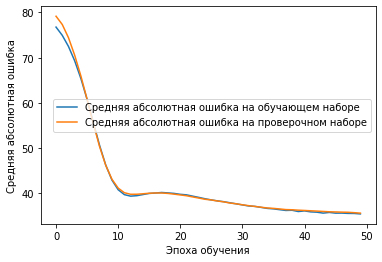

In [ ]:
plt.plot(history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_mae"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.xlabel("Эпоха обучения")
plt.ylabel("Средняя абсолютная ошибка")
plt.legend()
plt.show()

In [ ]:
pred = model.predict(xTrain01)   # предсказание и приводим его к начальному виду
pred = pred.flatten()
# Среднее значение ошибки 
delta = pred - yTrain
absDelta = abs(delta)
print("ошибка:", round(sum(absDelta) / len(absDelta), 2))

ошибка: 34.64


In [ ]:
yScaler = StandardScaler()  # нормализуем данные

yScaler.fit(yTrain.reshape(-1, 1))
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))  # нормализуем данные  по нормальному распределению

print(yTrainScaled.shape)
print("запрошенная з/п:", yTrain[1])           
print("она же в нормализованном виде:", yTrainScaled[1])     

(62967, 1)
запрошенная з/п: 40.0
она же в нормализованном виде: [-0.25055869]


In [ ]:
print(min(yTrain), max(yTrain))                 # мин и макс значения з/п /1000
print(min(yTrainScaled), max(yTrainScaled))     # тоже в нормализованном виде

0.001 32300.0
[-0.51559138] [213.50365486]


In [ ]:
modelS = Sequential()    # модель на стандартизированных данных

modelS.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
modelS.add(Dense(128, activation="relu"))
modelS.add(Dense(1000, activation="tanh"))
modelS.add(Dense(100, activation="relu"))
modelS.add(Dense(1, activation="linear"))

modelS.compile(optimizer=Adam(lr=1e-5), loss="mse", metrics=["mae"])


In [ ]:
history = modelS.fit(xTrain01, yTrainScaled, epochs=50, batch_size=1500, validation_split=0.15, verbose=1)

Epoch 1/50
36/36 [==============================] - 1s 7ms/step - loss: 1.7013 - mae: 0.3766 - val_loss: 0.1838 - val_mae: 0.3069
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6840 - mae: 0.2798 - val_loss: 0.1664 - val_mae: 0.2938
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 2.4273 - mae: 0.2672 - val_loss: 0.1530 - val_mae: 0.2754
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 1.9137 - mae: 0.2517 - val_loss: 0.1446 - val_mae: 0.2633
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6322 - mae: 0.2401 - val_loss: 0.1393 - val_mae: 0.2563
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 1.6179 - mae: 0.2385 - val_loss: 0.1355 - val_mae: 0.2496
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2601 - mae: 0.2342 - val_loss: 0.1325 - val_mae: 0.2453
Epoch 8/50
36/36 [==============================] - 0s 4ms/step - loss: 0.8596 - mae: 0.23

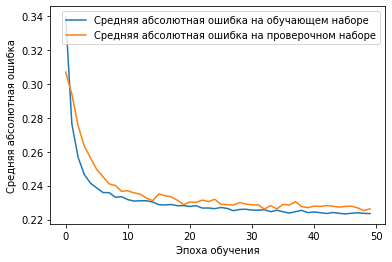

In [ ]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
pred = modelS.predict(xTrain01)    # предсказание и приводим его к начальному виду
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки 
delta = predUnscaled - yTrain
absDelta = abs(delta)
print("ошибка:", round(sum(absDelta) / len(absDelta), 2))

ошибка: 33.65


In [ ]:
yy = model.predict(xTrain01) # Результат для всего тренировочного набора

In [ ]:
n = 15
for i in range(n):
  print("Реальное значение:",yTrain[i], " Предсказанное значение:", yy[i][0], " Разница:", abs(yTrain[i]-yy[i][0]))

Реальное значение: 40.0  Предсказанное значение: 39.068092  Разница: 0.9319076538085938
Реальное значение: 40.0  Предсказанное значение: 66.819695  Разница: 26.81969451904297
Реальное значение: 300.0  Предсказанное значение: 141.32571  Разница: 158.67428588867188
Реальное значение: 180.0  Предсказанное значение: 148.98201  Разница: 31.017990112304688
Реальное значение: 40.0  Предсказанное значение: 49.041058  Разница: 9.041057586669922
Реальное значение: 200.0  Предсказанное значение: 130.68301  Разница: 69.31698608398438
Реальное значение: 120.0  Предсказанное значение: 151.77443  Разница: 31.774429321289062
Реальное значение: 50.0  Предсказанное значение: 71.330025  Разница: 21.33002471923828
Реальное значение: 60.0  Предсказанное значение: 88.77832  Разница: 28.7783203125
Реальное значение: 70.0  Предсказанное значение: 125.88035  Разница: 55.880348205566406
Реальное значение: 140.0  Предсказанное значение: 113.079285  Разница: 26.92071533203125
Реальное значение: 60.0  Предсказанно

In [ ]:
# Выкачиваем данные по резюме, загружаем сложные текстовые данные
def getXTrainTRez(values):
    xTrainTRez = []
    
    for val in values:
      currText = ""
      if (type(val[6]) != float):
          currText += val[6]
      
      if (getParameterSalary(val[1]) != -1):
          xTrainTRez.append(currText)
    
    xTrainTRez = np.array(xTrainTRez)
    
    return xTrainTRez

In [ ]:
xTrainTRez = getXTrainTRez(fixed_df.values)   # Вытаскиваем резюме для выборки

In [ ]:
print(xTrainTRez[11]) # Пример профессии 12го резюме

Опыт работы 26 лет 5 месяцев  Март 2019 — по настоящее время 3 месяца Управление Федеральной службы по надзору в сфере защиты прав потребителей и благополучия человека по городу Москве Москва , rospotrebnadzor.ru/ Государственные организации ... Государственные организации Ведущий специалист-эксперт Администрирование сетевой и компьютерной инфраструктуры.  Июль 2015 — Февраль  2019 3 года 8 месяцев ООО "ЭЛ-РИНО" Москва Телекоммуникации, связь ... Оптоволоконная связь Фиксированная связь Системный администратор Администрирование сетевой и компьютерной инфраструктуры большого бизнес-центра. Работа с арендаторами. Active Directories. Helpdesk. Установка и поддержка программных продуктов (MS Windows XP-10, MS Office, Консультант+ и пр.). Поддержка подключения всего бизнес-центра к Интернет. Большой опыт в обслуживании и ремонте офисной техники (HP, Canon, Epson, Kyocera, Ricoh и др.) Отличное знание мобильных устройств, Android.  Январь 2006 — Июнь  2015 9 лет 6 месяцев Банк «Инвестрастбан

In [ ]:
#Преобразовываю текстовые данные в числовые/векторные для обучения нейросетью

maxWordsCount = 5000 

# разбиение текста и преобразование в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTRez)         # даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # вытаскиваем индексы слов для просмотра

In [ ]:
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez) # Обучающие тесты в индексы

In [ ]:
xTrainRez01 = tokenizer.sequences_to_matrix(xTrainRezIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print("Размер обучающей выборки, сформированной по Bag of Words:", xTrainRez01.shape)                                      # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainRez01[0][0:100])

Размер обучающей выборки, сформированной по Bag of Words: (62967, 5000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [ ]:
print("Размер выборки самых частых слов:", xTrainRez01.shape)
print("Пример из отформатированной выборки:", xTrainRez01[555]) 

Размер выборки самых частых слов: (62967, 5000)
Пример из отформатированной выборки: [0. 0. 1. ... 0. 0. 0.]


In [ ]:
# functional API составная  нейро-сеть

In [ ]:
# подготовил xTrain01 и xTrainRez01,

In [ ]:
input1 = Input((xTrain01.shape[1],))
input3 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1)            # ветка х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)


x3 = Dense(1000, activation="tanh")(input3)  # ветка x3
x3 = Dense(20, activation = "elu")(x3)
x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x3])                    # объединяю две ветки

x = Dense(15, activation="linear")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="relu")(x)           # Финальный нейрон, делает регрессию

model = Model((input1, input3), x)           # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(lr=1e-3), loss="mse", metrics=["mae"])


In [ ]:
history = model.fit([xTrain01[:50000], xTrainRez01[:50000]], yTrain[:50000], epochs= 50, 
                    validation_data=([xTrain01[50000:], xTrainRez01[50000:]], yTrain[50000:]), verbose=1, shuffle=True)

Epoch 1/50
1563/1563 [==============================] - 6s 3ms/step - loss: 15778.9455 - mae: 36.8673 - val_loss: 1529.3700 - val_mae: 23.1186
Epoch 2/50
1563/1563 [==============================] - 5s 3ms/step - loss: 14118.6261 - mae: 27.3699 - val_loss: 1444.1422 - val_mae: 22.9557
Epoch 3/50
1563/1563 [==============================] - 5s 3ms/step - loss: 10275.6445 - mae: 25.5920 - val_loss: 1304.4883 - val_mae: 21.6507
Epoch 4/50
1563/1563 [==============================] - 5s 3ms/step - loss: 6229.8854 - mae: 24.5596 - val_loss: 1286.2250 - val_mae: 21.5578
Epoch 5/50
1563/1563 [==============================] - 5s 3ms/step - loss: 15575.2894 - mae: 23.8534 - val_loss: 1251.7256 - val_mae: 20.8758
Epoch 6/50
1563/1563 [==============================] - 5s 3ms/step - loss: 3916.6004 - mae: 22.6409 - val_loss: 1422.4429 - val_mae: 21.9398
Epoch 7/50
1563/1563 [==============================] - 5s 3ms/step - loss: 6316.3949 - mae: 22.4523 - val_loss: 1323.3256 - val_mae: 21.5575
Ep

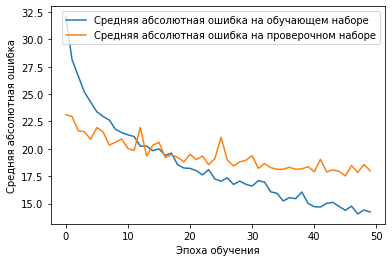

In [ ]:
plt.plot(history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_mae"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.xlabel("Эпоха обучения")
plt.ylabel("Средняя абсолютная ошибка")
plt.legend()
plt.show()

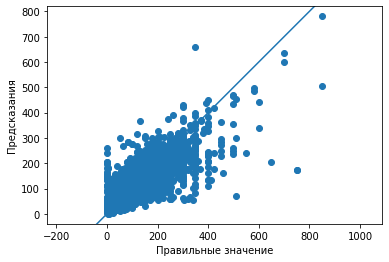

In [ ]:
yy = yTrain[50000:]                                           # Зарплата запрошенная
pred = model.predict([xTrain01[50000:], xTrainRez01[50000:]]) # Предсказанная зарплата
plt.scatter(yy, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 1000], [-1000, 1000])
plt.show()

In [ ]:
del xTrainRez01, xTrainRezIndexes # Удаляем некоторые переменные, иначе дальше может вылететь из-за нехватки памяти